In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras import layers, models
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.src.metrics import Precision

# Feature Engineering

In [20]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 1d convnet work
X = train_df.iloc[:, :-2].values
y = train_df['Activity'].values

X_test= test_df.iloc[:, :-2].values
y_test = test_df['Activity'].values

# Normalize the feature vectors
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.fit_transform(y_test)

# 2d convnet work
X2d = train_df.iloc[:, :-2].values
y2d = train_df['Activity'].values

X2d_test= test_df.iloc[:, :-2].values
y2d_test = test_df['Activity'].values

# Normalize the feature vectors
scaler = StandardScaler()
X2d = scaler.fit_transform(X2d)
X2d_test = scaler.fit_transform(X2d_test)

label_encoder = LabelEncoder()
y2d = label_encoder.fit_transform(y2d)
y2d_test = label_encoder.fit_transform(y2d_test)

# 1 dimension work
## Difference is in the X y variables array size (2 dimensional array)

In [21]:
# (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 2 dimension work
## Difference is in the X y variables array size (3 dimensional array)

In [33]:
# (samples, timesteps, features). 3d data
X2d = X2d.reshape(X2d.shape[0], X2d.shape[1], 1, 1)
X2d_test = X2d_test.reshape(X2d_test.shape[0], X2d_test.shape[1], 1, 1)

### One hot encoding

In [23]:
y = to_categorical(y)
y_test = to_categorical(y_test)

y2d = to_categorical(y2d)
y2d_test = to_categorical(y2d_test)

# Models

In [24]:
def makeModel1d():
    model = models.Sequential()
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision()])
    return model


def makeModel2d():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 1), activation='relu', input_shape=(X2d.shape[1], X2d.shape[2], 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(64, (3, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(128, (3, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision()])
    return model

# Stores the best model

In [25]:
class ModelObject:
    def __init__(self):
        self.epoch = None
        self.model = None
        self.batch = None
        self.accuracy = None
        self.loss = None
        self.modelDimension = None
        self.precision = None


# Fits the model

In [26]:
def fit(daModel, X_train, y_train, epoch, batch):
    return daModel.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_split=0.2)

# Variable epoch and batch sizes to be made for each iteration
## This is what runs all model variations. Simplify these lists to get a quicker run time (50 epoch, 512 batch to get best model [2d])

In [34]:
epochs_list = [50, 100, 150]
batch_sizes = [32, 64, 128, 256, 512]

# Determines the best model combo based on dimension, epoch, and batch size
### Variables to be run outside of the big double-for loop for singular best model runs

In [28]:
# Store the history for 1D and 2D models
history1d = {}
history2d = {}

best_model = ModelObject()
best_model.accuracy = 0
best_model.loss = 1
best_model.precision = 0

# Runs all iterations of epochs and batch sizes specified above
## Dont run this if you just want the already found, best model

In [80]:
for epochs in epochs_list:
    for batch_size in batch_sizes:

        model = makeModel1d()
        model2d = makeModel2d()
        history1d[(epochs, batch_size)] = fit(model, X, y, epochs, batch_size)
        history2d[(epochs, batch_size)] = fit(model2d, X2d, y2d, epochs, batch_size)
        test_loss, test_accuracy, test_precision = model.evaluate(X_test, y_test)
        test_loss2d, test_accuracy2d, test_precision2d = model2d.evaluate(X2d_test, y2d_test)

        if (best_model.accuracy < test_accuracy):
            best_model.model = model
            best_model.epoch = epochs
            best_model.modelDimension = 1
            best_model.batch = batch_size
            best_model.loss = test_loss
            best_model.accuracy = test_accuracy
            best_model.precision = test_precision

        if (best_model.accuracy < test_accuracy2d):
            best_model.model = model2d
            best_model.epoch = epochs
            best_model.modelDimension = 2
            best_model.batch = batch_size
            best_model.loss = test_loss2d
            best_model.accuracy = test_accuracy2d
            best_model.precision = test_precision2d
        print(f"{epochs}, {batch_size} completed for 1d and 2d")

Epoch 1/50
184/184 [==============================] - 9s 39ms/step - loss: 1.2829 - accuracy: 0.5577 - precision_8: 0.6776 - val_loss: 4.0027 - val_accuracy: 0.1822 - val_precision_8: 0.1861
Epoch 2/50
184/184 [==============================] - 7s 37ms/step - loss: 0.6525 - accuracy: 0.7385 - precision_8: 0.8371 - val_loss: 0.3966 - val_accuracy: 0.8477 - val_precision_8: 0.8736
Epoch 3/50
184/184 [==============================] - 7s 36ms/step - loss: 0.4910 - accuracy: 0.7960 - precision_8: 0.8907 - val_loss: 0.2183 - val_accuracy: 0.9286 - val_precision_8: 0.9326
Epoch 4/50
184/184 [==============================] - 7s 37ms/step - loss: 0.4097 - accuracy: 0.8272 - precision_8: 0.9237 - val_loss: 0.2067 - val_accuracy: 0.9307 - val_precision_8: 0.9365
Epoch 5/50
184/184 [==============================] - 7s 36ms/step - loss: 0.3388 - accuracy: 0.8487 - precision_8: 0.9461 - val_loss: 0.1424 - val_accuracy: 0.9497 - val_precision_8: 0.9502
Epoch 6/50
184/184 [=========================

# Makes the Best Model without iterating over every epoch, dimension, and batch size
## Best Model found was 2d, 50 epoch, 512 batch size

In [29]:
model2d = makeModel2d()
history2d[(50, 512)] = fit(model2d, X2d, y2d, 50, 512)
test_loss2d, test_accuracy2d, test_precision2d = model2d.evaluate(X2d_test, y2d_test)
best_model.model = model2d
best_model.epoch = 50
best_model.modelDimension = 2
best_model.batch = 512
best_model.loss = test_loss2d
best_model.accuracy = test_accuracy2d
best_model.precision = test_precision2d

Epoch 1/50
12/12 [==============================] - 3s 198ms/step - loss: 1.9791 - accuracy: 0.4103 - precision_2: 0.4670 - val_loss: 1.6868 - val_accuracy: 0.6683 - val_precision_2: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 2s 181ms/step - loss: 0.9929 - accuracy: 0.6206 - precision_2: 0.7321 - val_loss: 1.4252 - val_accuracy: 0.5765 - val_precision_2: 0.5909
Epoch 3/50
12/12 [==============================] - 2s 177ms/step - loss: 0.7063 - accuracy: 0.7227 - precision_2: 0.8212 - val_loss: 1.6451 - val_accuracy: 0.3780 - val_precision_2: 0.3613
Epoch 4/50
12/12 [==============================] - 2s 175ms/step - loss: 0.5312 - accuracy: 0.7980 - precision_2: 0.8701 - val_loss: 2.2471 - val_accuracy: 0.2121 - val_precision_2: 0.2133
Epoch 5/50
12/12 [==============================] - 2s 171ms/step - loss: 0.4182 - accuracy: 0.8415 - precision_2: 0.8880 - val_loss: 2.7798 - val_accuracy: 0.1917 - val_precision_2: 0.1895
Epoch 6/50
12/12 [============================

# Prediction on the test dataset

In [35]:
y_pred_test = best_model.model.predict(X_test)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

93/93 [==============================] - 1s 6ms/step


### Data reduction for visualization and decoding labels

In [36]:
# Reduce the dimensionality to 50 components (samples, features) for PCA. Got rid of timesteps and made X 2d
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Apply PCA for dimensionality reduction to 50 components to simplify data.
# I can use just tsne but using PCA first to reduce dimensionality introduces less noise and more consistency
pca = PCA(n_components=50)
x_pca_test = pca.fit_transform(X_test_reshaped)

# Reduce the dimensionality to 2 components to simplify data for scatter plot.
tsne = TSNE(n_components=2, random_state=42)
x_tsne_test = tsne.fit_transform(x_pca_test)

# Get the true labels for the test data
y_test_labels = np.argmax(y_test, axis=1)

activity_names = label_encoder.classes_

## Prediction visualization

Wrong 113, Right 2834, Actual accuracy:0.9616559147834778


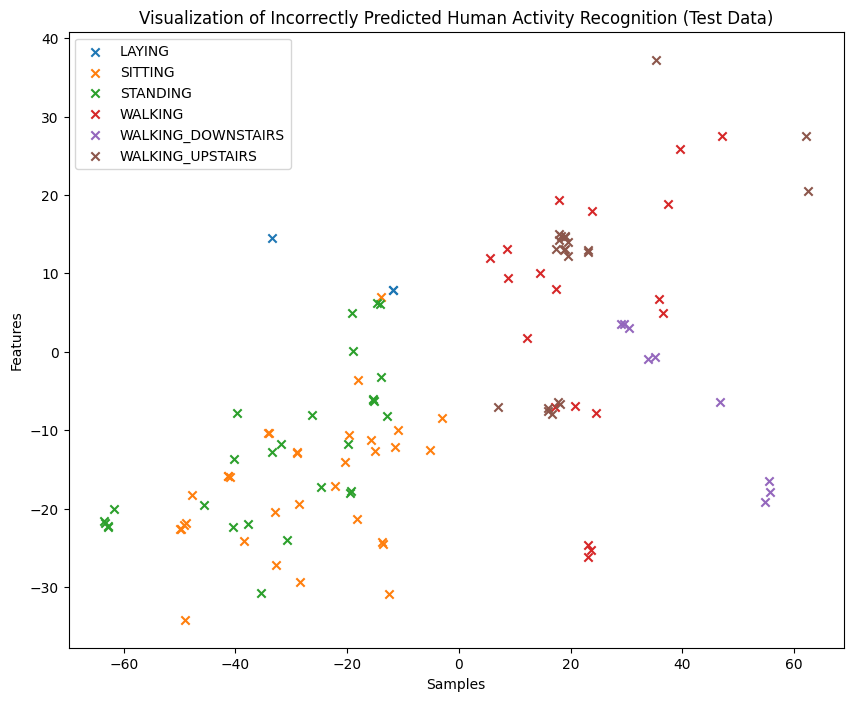

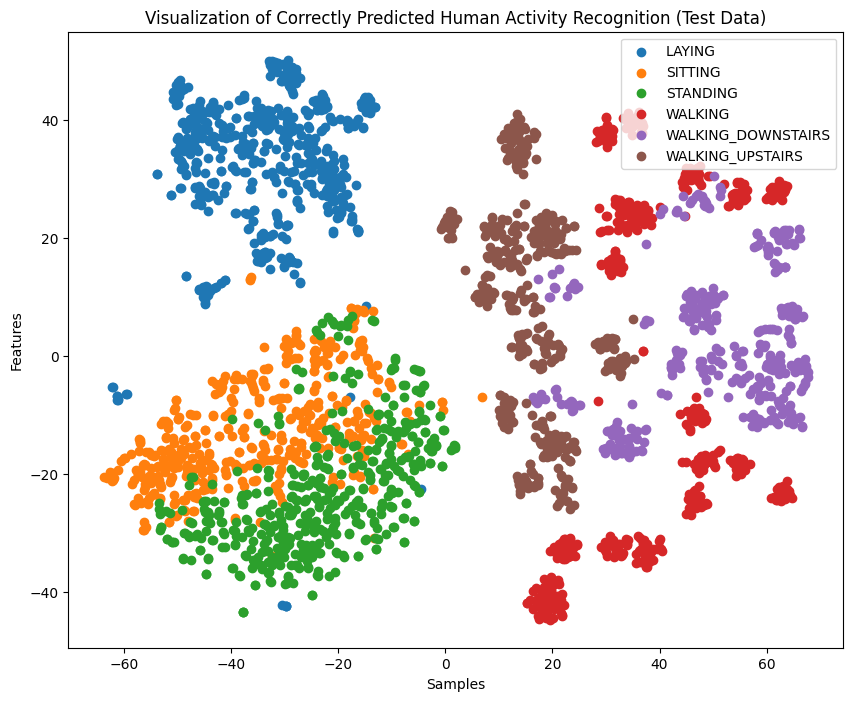

In [32]:
wrong = 0
right = 0

for i in range(len(y_test_labels)):
    if y_test_labels[i] != y_pred_test_labels[i]:
        wrong += 1
    else:
        right += 1

print(f"Wrong {wrong}, Right {right}, Actual accuracy:{best_model.accuracy}")

plt.figure(figsize=(10, 8))
for i, activity_name in enumerate(activity_names):
    plt.scatter(x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels != y_test_labels), 0],
                x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels != y_test_labels), 1],
                label=f"{activity_name}", marker='x')

plt.title("Visualization of Incorrectly Predicted Human Activity Recognition (Test Data)")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Features")
plt.show()


plt.figure(figsize=(10, 8))
for i, activity_name in enumerate(activity_names):
    plt.scatter(x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels == y_test_labels), 0],
                x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels == y_test_labels), 1],
                label=f"{activity_name}", marker='o')

plt.title("Visualization of Correctly Predicted Human Activity Recognition (Test Data)")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Features")
plt.show()


## Best Model Statistics

Best model accuracy: 0.9609772562980652
Best model dimension: 2d
Best model loss: 0.2458425909280777
Best model precision: 0.9609507918357849
Best model epoch: 50
Best model batch size: 512


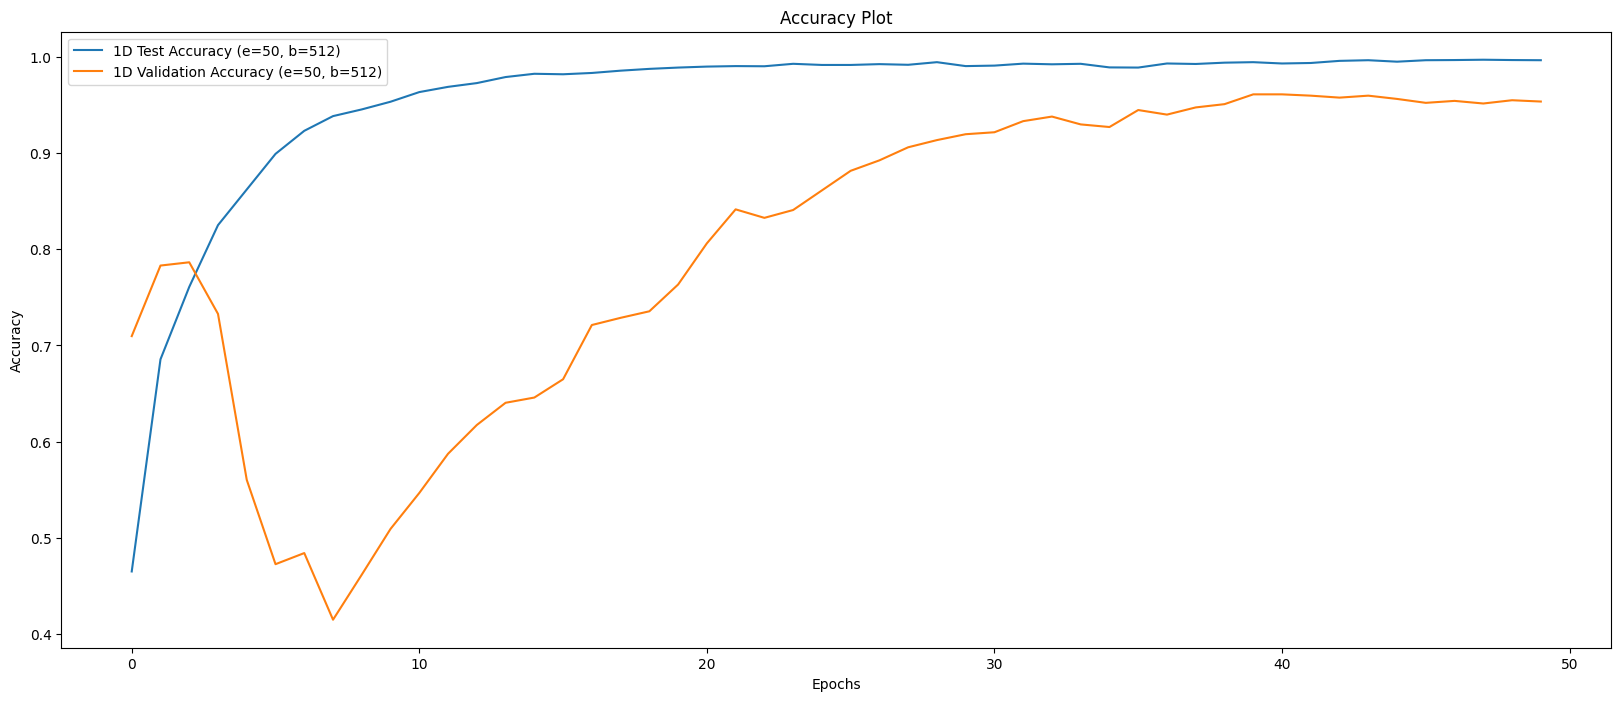

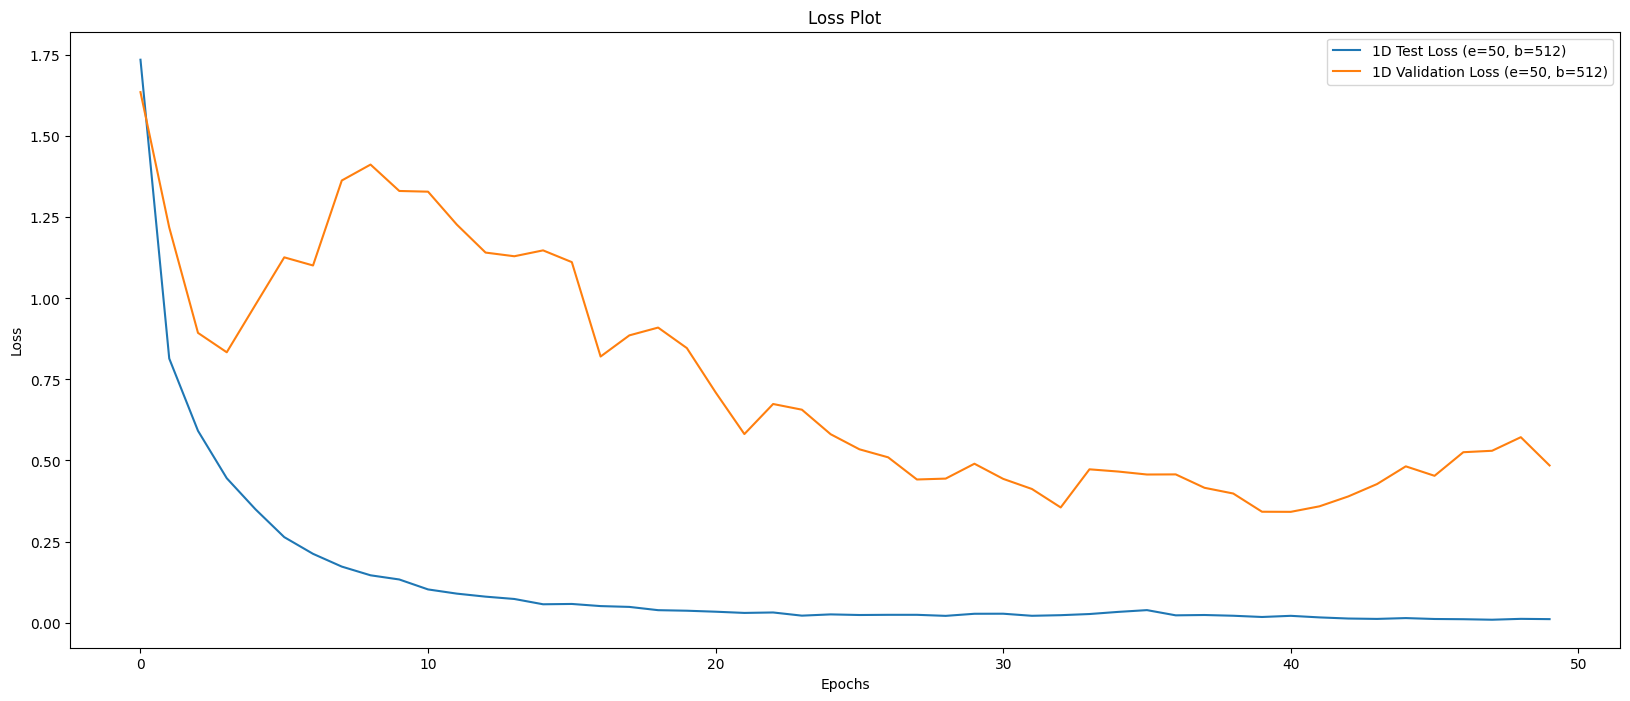

In [124]:
# Plot Accuracy
print(f"Best model accuracy: {best_model.accuracy}")
print(f"Best model dimension: {best_model.modelDimension}d")
print(f"Best model loss: {best_model.loss}")
print(f"Best model precision: {best_model.precision}")
print(f"Best model epoch: {best_model.epoch}")
print(f"Best model batch size: {best_model.batch}")

plt.figure(figsize=(20, 8))
plt.plot(history2d[(best_model.epoch, best_model.batch)].history['accuracy'], label=f'1D Test Accuracy (e={best_model.epoch}, b={best_model.batch})')
plt.plot(history2d[(best_model.epoch, best_model.batch)].history['val_accuracy'], label=f'1D Validation Accuracy (e={best_model.epoch}, b={best_model.batch})')

plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(20, 8))
plt.plot(history2d[(best_model.epoch, best_model.batch)].history['loss'], label=f'1D Test Loss (e={best_model.epoch}, b={best_model.batch})')
plt.plot(history2d[(best_model.epoch, best_model.batch)].history['val_loss'], label=f'1D Validation Loss (e={best_model.epoch}, b={best_model.batch})')

plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 1d models - DO NOT RUN AGAIN UNLESS YOU HAVE ALL EPOCH AND BATCH SIZE MODEL VARIATIONS [Found above]

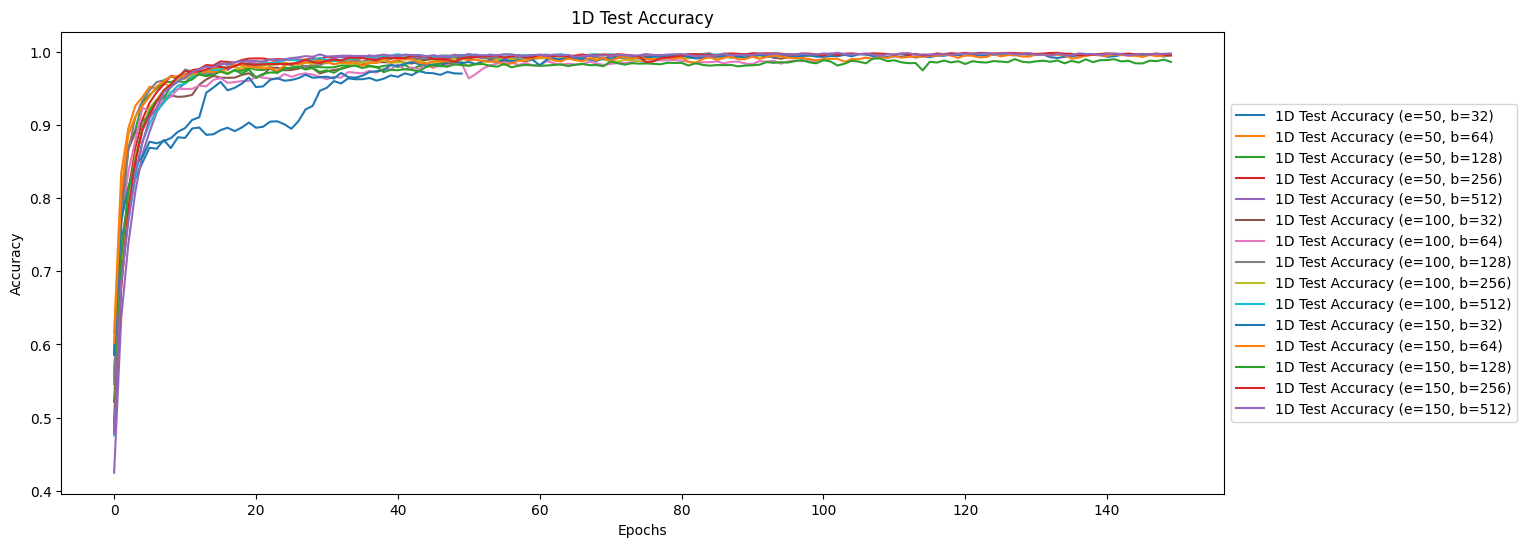

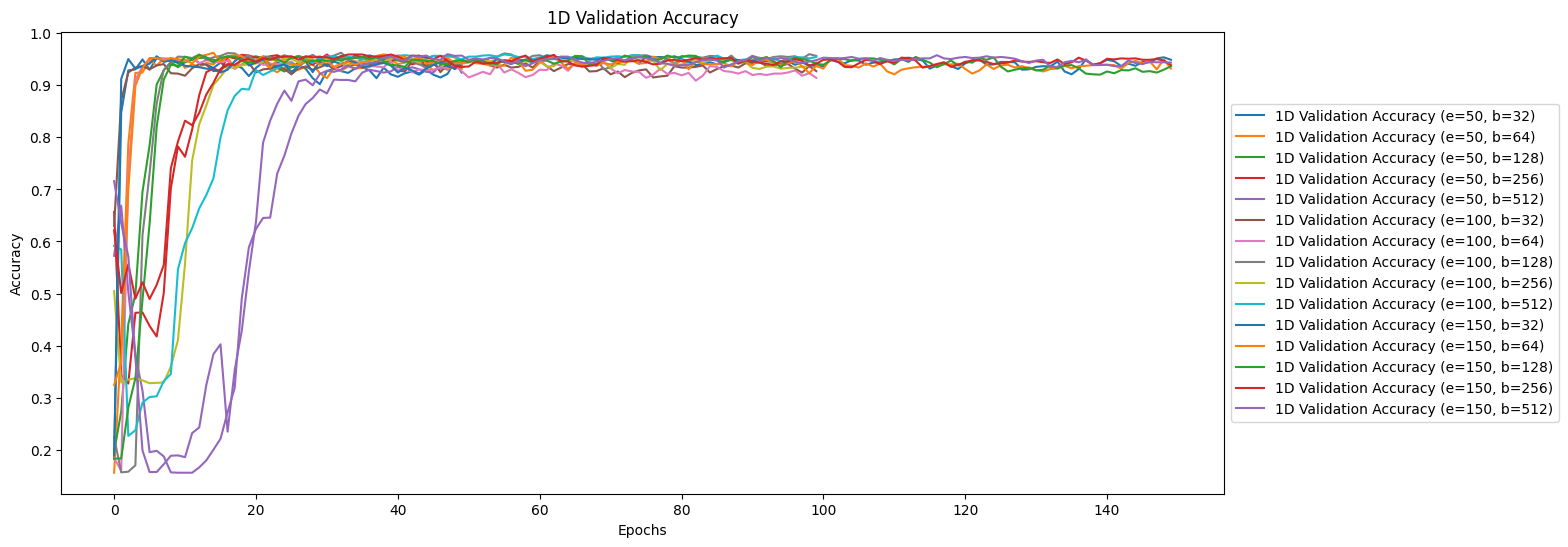

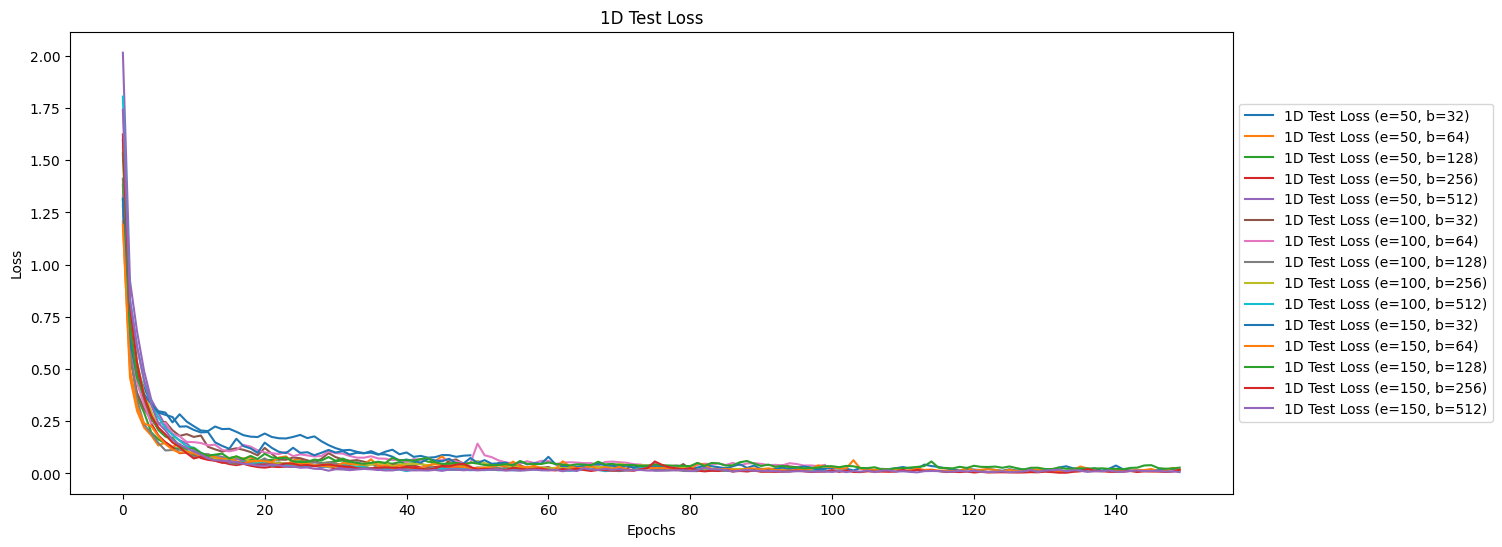

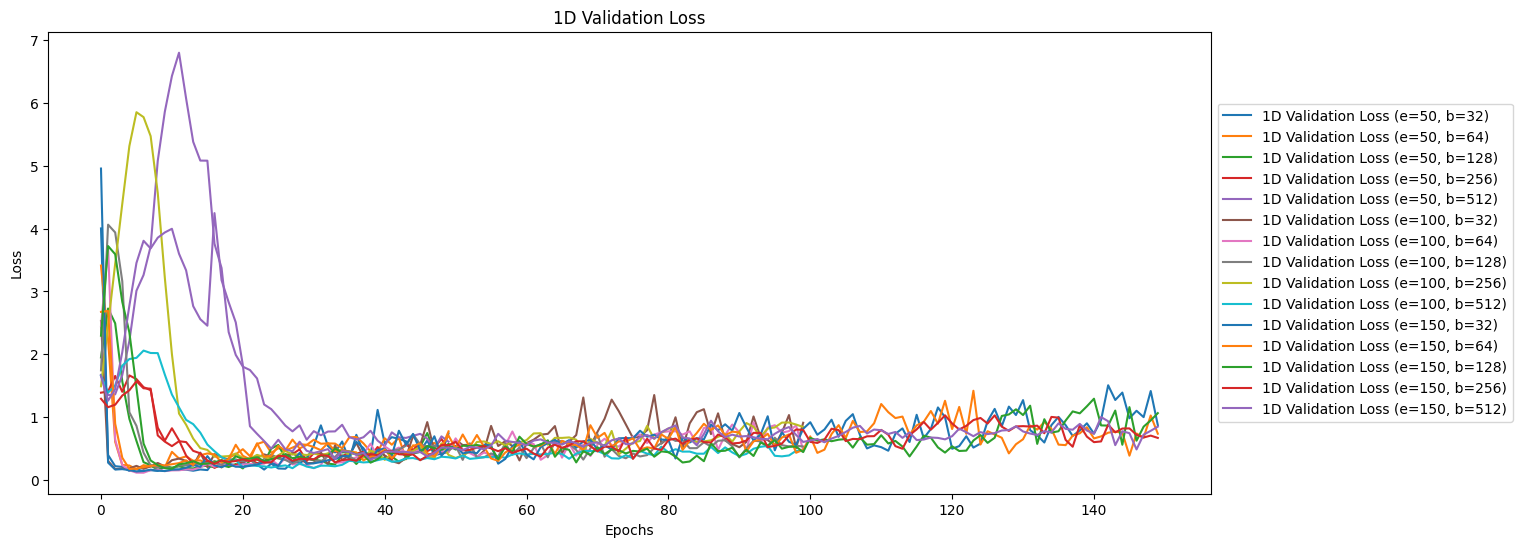

In [126]:
# 1D models
# Plot 1D Test Accuracy
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history1d.keys():
    plt.plot(history1d[(epochs, batch_size)].history['accuracy'], label=f'1D Test Accuracy (e={epochs}, b={batch_size})')
plt.title('1D Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot 1D Validation Accuracy
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history1d.keys():
    plt.plot(history1d[(epochs, batch_size)].history['val_accuracy'], label=f'1D Validation Accuracy (e={epochs}, b={batch_size})')
plt.title('1D Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot 1D Test Loss
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history1d.keys():
    plt.plot(history1d[(epochs, batch_size)].history['loss'], label=f'1D Test Loss (e={epochs}, b={batch_size})')
plt.title('1D Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot 1D Validation Loss
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history1d.keys():
    plt.plot(history1d[(epochs, batch_size)].history['val_loss'], label=f'1D Validation Loss (e={epochs}, b={batch_size})')
plt.title('1D Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##  models - DO NOT RUN AGAIN UNLESS YOU HAVE ALL EPOCH AND BATCH SIZE MODEL VARIATIONS [Found above]

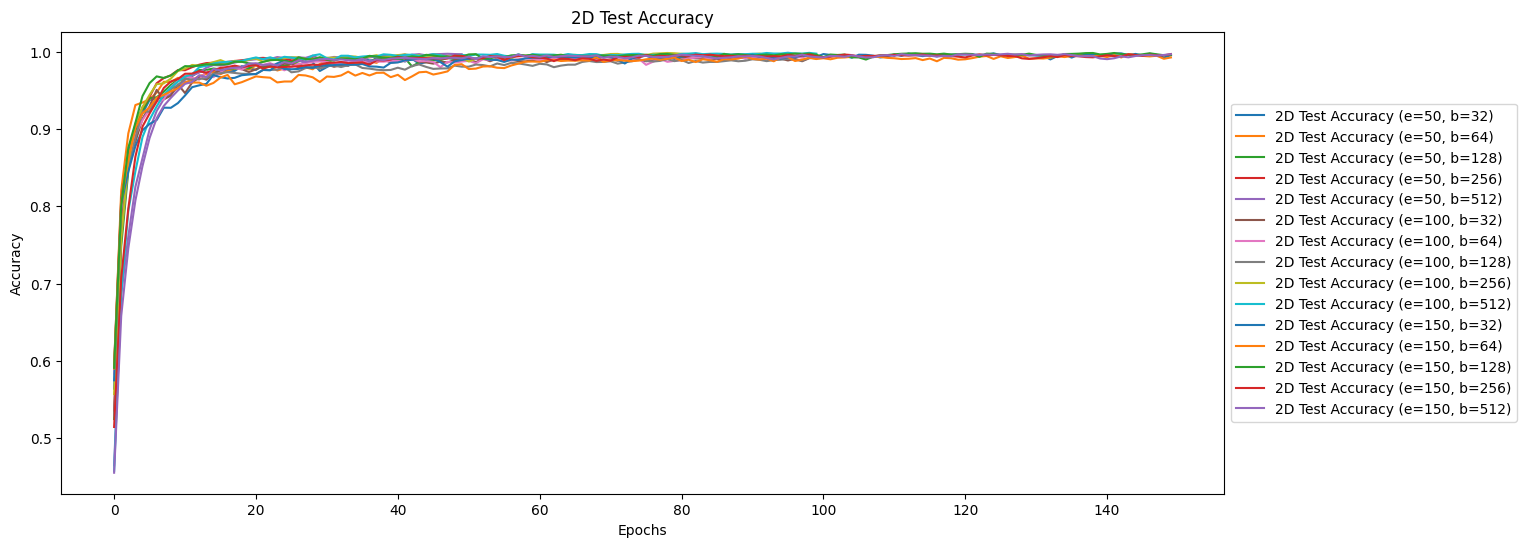

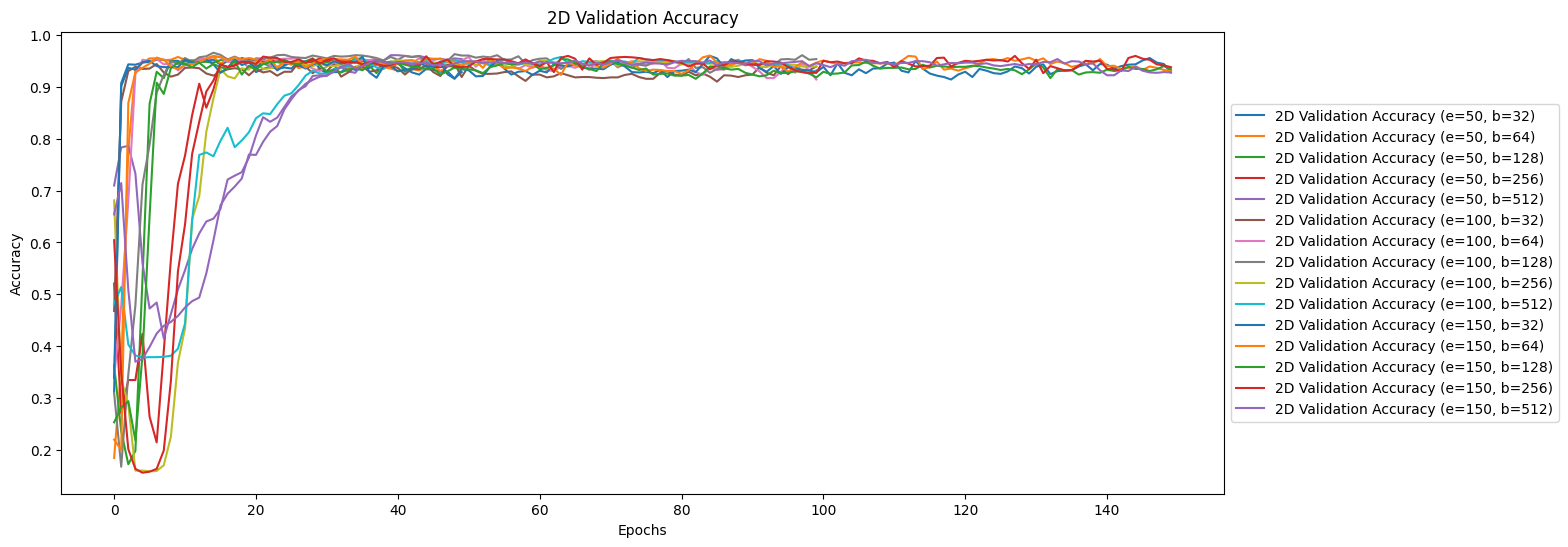

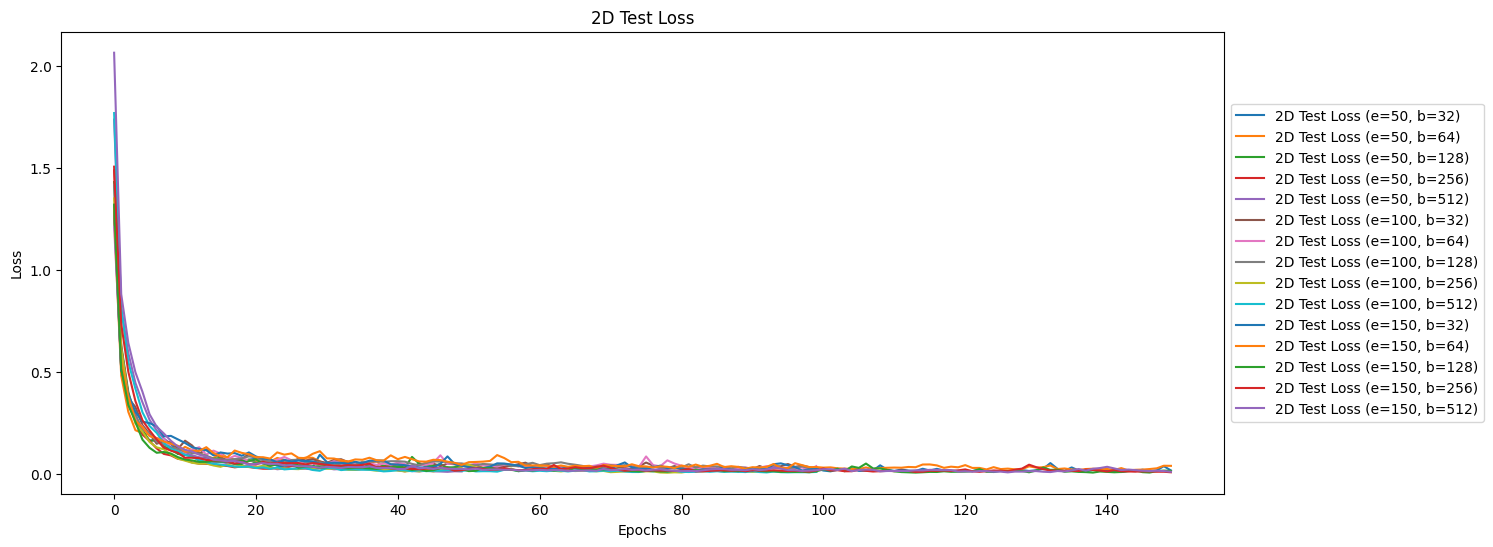

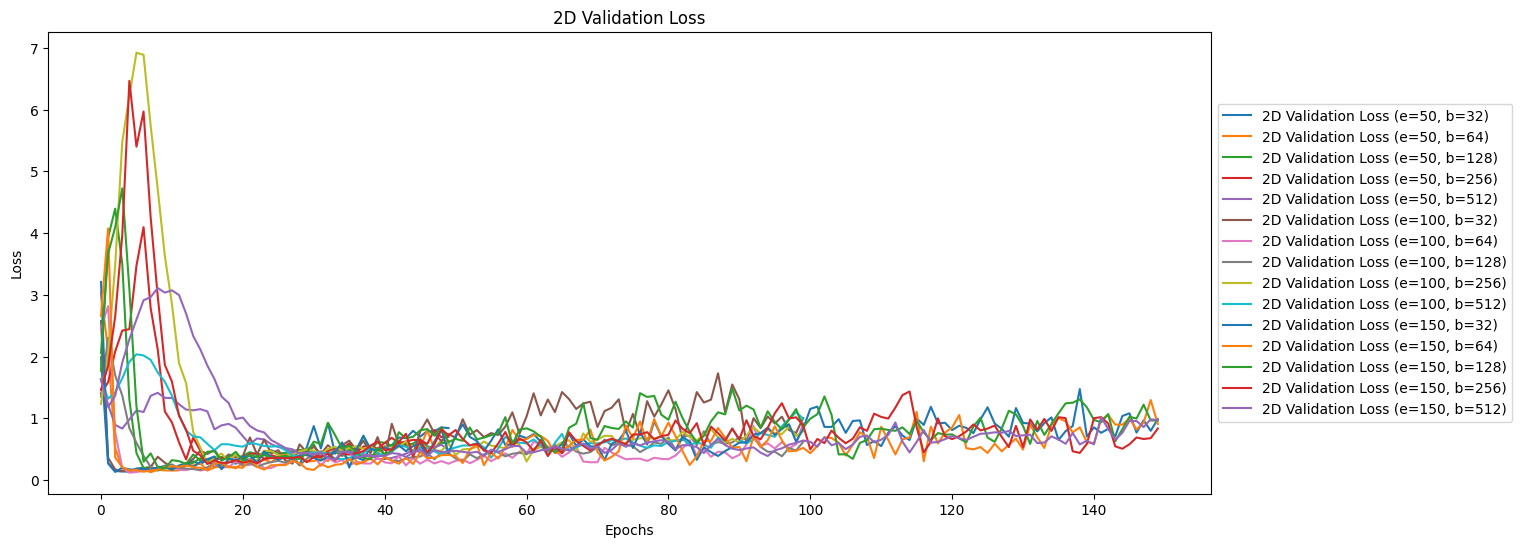

In [127]:
# 2D models
# Plot 2D Test Accuracy
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history2d.keys():
    plt.plot(history2d[(epochs, batch_size)].history['accuracy'], label=f'2D Test Accuracy (e={epochs}, b={batch_size})')
plt.title('2D Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot 2D Validation Accuracy
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history2d.keys():
    plt.plot(history2d[(epochs, batch_size)].history['val_accuracy'], label=f'2D Validation Accuracy (e={epochs}, b={batch_size})')
plt.title('2D Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot 2D Test Loss
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history2d.keys():
    plt.plot(history2d[(epochs, batch_size)].history['loss'], label=f'2D Test Loss (e={epochs}, b={batch_size})')
plt.title('2D Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot 2D Validation Loss
plt.figure(figsize=(15, 6))
for (epochs, batch_size) in history2d.keys():
    plt.plot(history2d[(epochs, batch_size)].history['val_loss'], label=f'2D Validation Loss (e={epochs}, b={batch_size})')
plt.title('2D Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [110]:

""" Add a new plot for Precision
plt.figure(figsize=(20, 8))

for (epochs, batch_size) in history1d.keys():
    plt.plot(history1d[(epochs, batch_size)].history['precision_4'], label=f'1D Train Precision (e={epochs}, b={batch_size})')
    plt.plot(history1d[(epochs, batch_size)].history['val_precision_4'], label=f'1D Train Precision (e={epochs}, b={batch_size})')

plt.title('Precision Plot')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()"""

" Add a new plot for Precision\nplt.figure(figsize=(20, 8))\n\nfor (epochs, batch_size) in history1d.keys():\n    plt.plot(history1d[(epochs, batch_size)].history['precision_4'], label=f'1D Train Precision (e={epochs}, b={batch_size})')\n    plt.plot(history1d[(epochs, batch_size)].history['val_precision_4'], label=f'1D Train Precision (e={epochs}, b={batch_size})')\n\nplt.title('Precision Plot')\nplt.xlabel('Epochs')\nplt.ylabel('Precision')\nplt.legend()\n\nplt.show()"

In [107]:
"""
Plot Precision
plt.figure(figsize=(20, 8))
plt.plot(history1d[(best_model.epoch, best_model.batch)].history['precision_6'], label=f'1D Train precision (e={best_model.epoch}, b={best_model.batch})')
plt.plot(history1d[(best_model.epoch, best_model.batch)].history['val_precision_6'], label=f'1D Test precision (e={best_model.epoch}, b={best_model.batch})')

plt.title('precision Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()"""


"\nPlot Precision\nplt.figure(figsize=(20, 8))\nplt.plot(history1d[(best_model.epoch, best_model.batch)].history['precision_6'], label=f'1D Train precision (e={best_model.epoch}, b={best_model.batch})')\nplt.plot(history1d[(best_model.epoch, best_model.batch)].history['val_precision_6'], label=f'1D Test precision (e={best_model.epoch}, b={best_model.batch})')\n\nplt.title('precision Plot')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()"

In [114]:

"""# Add a new plot for Precision
plt.figure(figsize=(20, 8))

for (epochs, batch_size) in history2d.keys():
    plt.plot(history2d[(epochs, batch_size)].history['precision_20'], label=f'2D Train Precision (e={epochs}, b={batch_size})')
    plt.plot(history2d[(epochs, batch_size)].history['val_precision_20'], label=f'2D Train Precision (e={epochs}, b={batch_size})')

plt.title('Precision Plot')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()"""

"# Add a new plot for Precision\nplt.figure(figsize=(20, 8))\n\nfor (epochs, batch_size) in history2d.keys():\n    plt.plot(history2d[(epochs, batch_size)].history['precision_20'], label=f'2D Train Precision (e={epochs}, b={batch_size})')\n    plt.plot(history2d[(epochs, batch_size)].history['val_precision_20'], label=f'2D Train Precision (e={epochs}, b={batch_size})')\n\nplt.title('Precision Plot')\nplt.xlabel('Epochs')\nplt.ylabel('Precision')\nplt.legend()\n\nplt.show()"